In [2]:
# Running this command to activate autocomplete.

%config Completer.use_jedi = False

In [187]:
# Importing the necessary libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix ,ConfusionMatrixDisplay, mean_absolute_error
import eli5
from eli5.sklearn import PermutationImportance
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [4]:
# Loading the dataset directly from the Machine leanring repository.

df =  pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/thyroid0387.data")

In [5]:
df.head()

,29,F,f,f.1,f.2,f.3,f.4,f.5,f.6,t,...,f.14,?.1,f.15,?.2,f.16,?.3,f.17,?.4,other,-[840801013]
0,29,F,f,f,f,f,f,f,f,f,...,t,128,f,?,f,?,f,?,other,-[840801014]
1,41,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,11,other,-[840801042]
2,36,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,26,other,-[840803046]
3,32,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,36,other,S[840803047]
4,60,F,f,f,f,f,f,f,f,f,...,f,?,f,?,f,?,t,26,other,-[840803048]


In [6]:
df.shape

(9171, 30)

# Data Pre-Processing

In [7]:
# Saving the first character in a new column. Because thats what matter for this problem statement.

df["outcome"] = df["-[840801013]"].str[0]

In [8]:
# Dropping this columns as we no longer need.

df.drop(columns="-[840801013]", inplace=True)

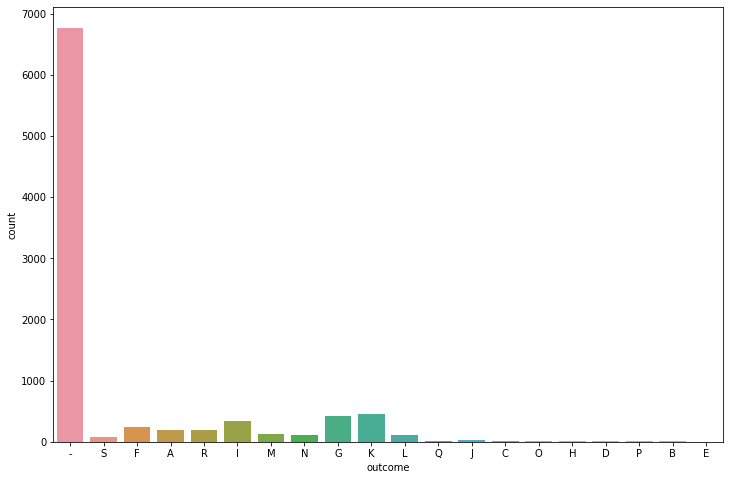

In [9]:
# Visualizing all the outcomes.

plt.figure(figsize=(12,8))
sns.countplot(x = df.outcome)

In [10]:
# Chekcing the total number of unique outcomes.

df.outcome.unique()

array(['-', 'S', 'F', 'A', 'R', 'I', 'M', 'N', 'G', 'K', 'L', 'Q', 'J',
       'C', 'O', 'H', 'D', 'P', 'B', 'E'], dtype=object)

In [11]:
# Replacing all possible disease outcomes into one category - "yes".

list = ['S', 'F', 'A', 'R', 'I', 'M', 'N', 'G', 'K', 'L', 'Q', 'J',
       'C', 'O', 'H', 'D', 'P', 'B', 'E']

df['outcome'].replace(to_replace=list, value="yes", inplace=True)

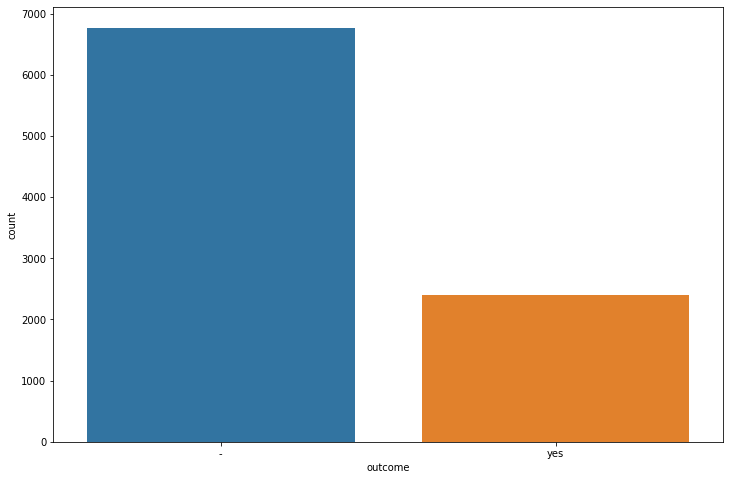

In [12]:
# Visualizing the outcomes after the processing the data.

plt.figure(figsize=(12,8))
sns.countplot(x = df.outcome)

At this point, we see that our data is imbalanced.

In [13]:
# Replacing the binary outputs into integer values 0 and 1 for simplicity.

df.outcome.replace({"-":0, "yes":1}, inplace=True)

In [14]:
# Here we see that the column names doesn't make any sense. So, I replaced the present column names into understandable form 
# with the help of readme file.

df.columns

Index(['29', 'F', 'f', 'f.1', 'f.2', 'f.3', 'f.4', 'f.5', 'f.6', 't', 'f.7',
       'f.8', 'f.9', 'f.10', 'f.11', 'f.12', 't.1', '0.3', 'f.13', '?', 'f.14',
       '?.1', 'f.15', '?.2', 'f.16', '?.3', 'f.17', '?.4', 'other', 'outcome'],
      dtype='object')

In [15]:
# Here I replace the column names with more simple and understandable form.

df.rename(columns = {"29":"age", "F":"sex", "f":"thyroxine", "f.1":"query_thyroxine", "f.2":"medication","f.3":"sick", 
                        "f.4":"pregnant", "f.5":"surgery", "f.6":"I131_treatment", "t":"query_hypothyroid", 
                        "f.7":"query_hyperthyroid", "f.8":"lithium", "f.9":"goitre", "f.10":"tumor", "f.11":"hypopituitary", 
                        "f.12":"psych", "t.1":"TSH_measured","0.3":"TSH", "f.13":"T3_measured", "?":"T3", 
                        "f.14":"TT4_measured", "?.1":"TT4", "f.15":"T4U_measured", "?.2":"T4U", "f.16":"FTI_measured", 
                        "?.3":"FTI", "f.17":"TBG_measured", "?.4":"TBG", "other":"referral_source"}, inplace=True)

In [16]:
# We saw that the null values were imputed by a "?". To keep things simple I re-converted the "?" into numpy null value.

df.replace({"?":np.nan}, inplace=True)

In [17]:
# Checking the null values of each column.

df.isnull().sum()

age                      0
sex                    307
thyroxine                0
query_thyroxine          0
medication               0
sick                     0
pregnant                 0
surgery                  0
I131_treatment           0
query_hypothyroid        0
query_hyperthyroid       0
lithium                  0
goitre                   0
tumor                    0
hypopituitary            0
psych                    0
TSH_measured             0
TSH                    842
T3_measured              0
T3                    2603
TT4_measured             0
TT4                    441
T4U_measured             0
T4U                    808
FTI_measured             0
FTI                    801
TBG_measured             0
TBG                   8822
referral_source          0
outcome                  0
dtype: int64

In [18]:
# The columns "TBG" and "T3" has a lot of null values. Imputing these null values might reduce variance and might tease 
# the model into giving more importance to a particular case.

df.drop(columns=["TBG", "T3"], inplace=True)

In [19]:
# The column "sex" has a few null values and I thought imputing them with "unknown" makes more sense 
# than male "M" or "female" "F".

df.sex.fillna("unknown", inplace=True)

In [20]:
# Coverting the datatype of continous features into numeric type.

df.TSH = pd.to_numeric(df.TSH)
df.TT4 = pd.to_numeric(df.TT4)
df.T4U = pd.to_numeric(df.T4U)
df.FTI = pd.to_numeric(df.FTI)

In [21]:
df.dtypes

age                     int64
sex                    object
thyroxine              object
query_thyroxine        object
medication             object
sick                   object
pregnant               object
surgery                object
I131_treatment         object
query_hypothyroid      object
query_hyperthyroid     object
lithium                object
goitre                 object
tumor                  object
hypopituitary          object
psych                  object
TSH_measured           object
TSH                   float64
T3_measured            object
TT4_measured           object
TT4                   float64
T4U_measured           object
T4U                   float64
FTI_measured           object
FTI                   float64
TBG_measured           object
referral_source        object
outcome                 int64
dtype: object

# Exploratory Data Analysis

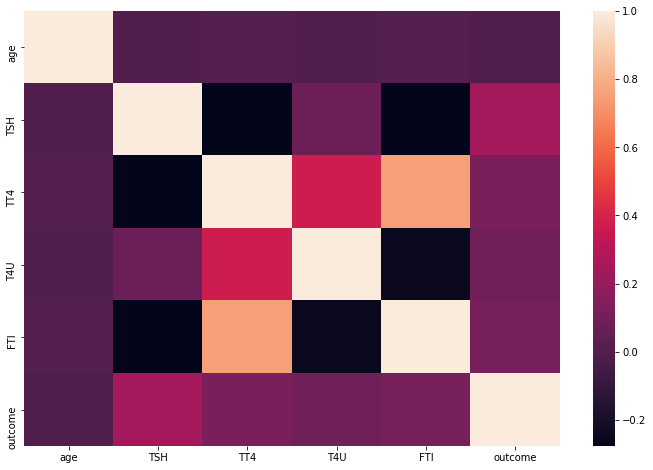

In [22]:
# Checking feature correlation.

plt.figure(figsize=(12,8))
sns.heatmap(df.corr())

In [23]:
# Creating a function to visualize the distribution of each feature.

def viz(feature_name):
    print(feature_name.describe())
    plt.figure(figsize=(12,8))
    sns.distplot(feature_name)

count     9171.000000
mean        73.560680
std       1184.041182
min          1.000000
25%         37.000000
50%         55.000000
75%         68.000000
max      65526.000000
Name: age, dtype: float64


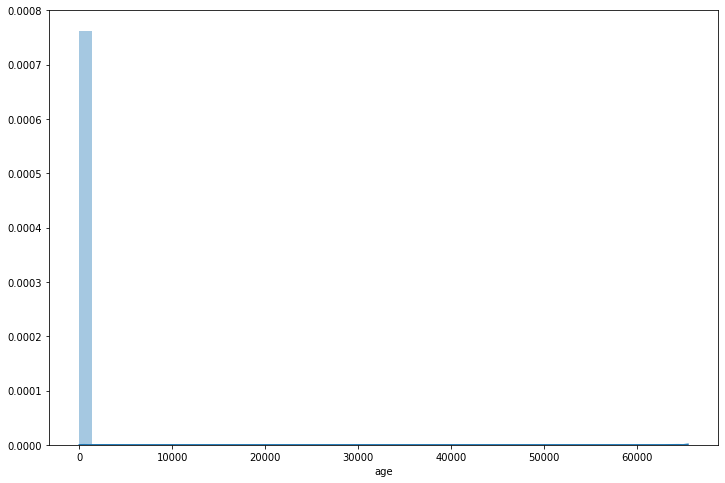

In [24]:
viz(df.age)

In [25]:
df[df["age"]>100]

,age,sex,thyroxine,query_thyroxine,medication,sick,pregnant,surgery,I131_treatment,query_hypothyroid,...,T3_measured,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,outcome
2975,455,F,f,f,f,f,f,f,f,f,...,t,t,118.0,t,1.13,t,104.0,f,SVI,0
5709,65511,M,f,f,f,f,f,f,f,f,...,t,t,113.0,t,1.08,t,104.0,f,other,0
6391,65512,M,f,f,f,f,f,f,f,f,...,t,t,112.0,t,0.84,t,133.0,f,other,0
8104,65526,F,f,f,f,f,f,f,f,f,...,f,t,132.0,t,1.02,t,129.0,f,other,0


In [26]:
index_age = df[df["age"]>100].index

df.drop(index_age, inplace=True)

In [27]:
df

,age,sex,thyroxine,query_thyroxine,medication,sick,pregnant,surgery,I131_treatment,query_hypothyroid,...,T3_measured,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,outcome
0,29,F,f,f,f,f,f,f,f,f,...,t,t,128.0,f,NaN,f,NaN,f,other,0
1,41,F,f,f,f,f,f,f,f,f,...,f,f,NaN,f,NaN,f,NaN,t,other,0
2,36,F,f,f,f,f,f,f,f,f,...,f,f,NaN,f,NaN,f,NaN,t,other,0
3,32,F,f,f,f,f,f,f,f,f,...,f,f,NaN,f,NaN,f,NaN,t,other,1
4,60,F,f,f,f,f,f,f,f,f,...,f,f,NaN,f,NaN,f,NaN,t,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9166,56,M,f,f,f,f,f,f,f,f,...,f,t,64.0,t,0.83,t,77.0,f,SVI,0
9167,22,M,f,f,f,f,f,f,f,f,...,f,t,91.0,t,0.92,t,99.0,f,SVI,0
9168,69,M,f,f,f,f,f,f,f,f,...,f,t,113.0,t,1.27,t,89.0,f,SVI,1
9169,47,F,f,f,f,f,f,f,f,f,...,f,t,75.0,t,0.85,t,88.0,f,other,0


count    9167.000000
mean       52.102214
std        18.909789
min         1.000000
25%        37.000000
50%        55.000000
75%        67.000000
max        97.000000
Name: age, dtype: float64


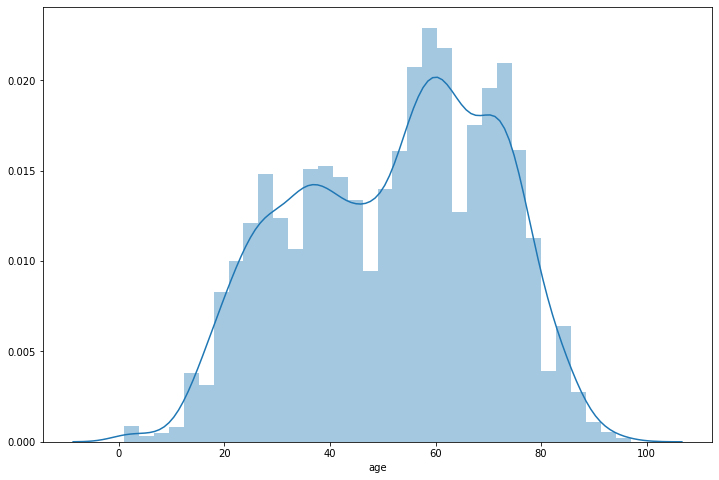

In [28]:
viz(df.age)

count    8325.000000
mean        5.221139
std        24.191007
min         0.005000
25%         0.470000
50%         1.400000
75%         2.700000
max       530.000000
Name: TSH, dtype: float64


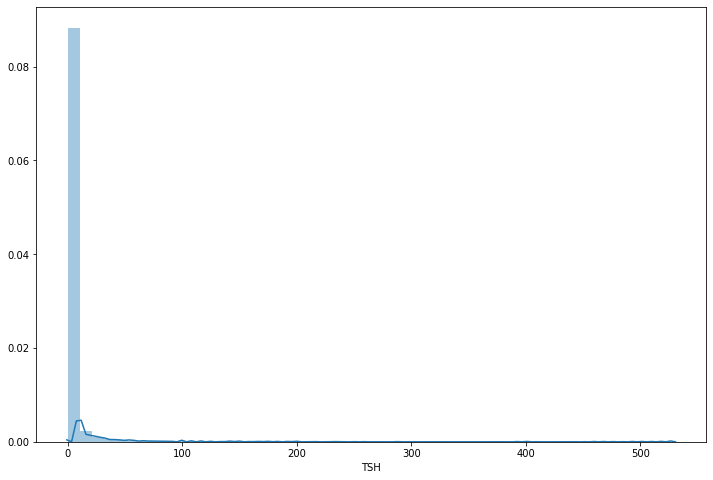

In [29]:
viz(df.TSH)

In [30]:
# Thyroid Stimulating hormone (TSH) value is usually in the range of 0.45 to 4.5 milliunits per litre. But it can reach upto 
# 8.9 milliunits per litre or higher in older people. Keeping all those facts in mind I feel a threshold of 15 is more 
# than sufficient for this problem statement. Beyond this threshold we will consider it as an abnormal case / human error.

df[df["TSH"]>15]

,age,sex,thyroxine,query_thyroxine,medication,sick,pregnant,surgery,I131_treatment,query_hypothyroid,...,T3_measured,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,referral_source,outcome
17,63,F,t,f,f,t,f,f,f,f,...,f,t,48.0,t,1.02,t,47.0,f,other,1
42,41,F,f,f,f,f,f,f,f,f,...,f,t,33.0,t,1.07,t,31.0,f,other,1
78,27,F,f,f,f,f,f,f,f,f,...,t,t,7.5,t,0.94,t,7.5,f,other,1
166,40,F,f,f,f,f,f,f,f,f,...,t,t,3.9,t,0.83,t,5.0,t,other,1
179,27,F,t,f,f,f,f,t,f,t,...,t,t,79.0,t,0.92,t,86.0,f,other,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9073,68,F,f,f,f,f,f,f,f,f,...,f,t,63.0,t,1.01,t,62.0,f,SVHC,1
9096,15,F,f,f,f,f,f,f,f,f,...,f,t,208.0,t,2.03,t,102.0,f,other,1
9122,75,F,f,f,f,f,f,f,f,f,...,t,t,104.0,t,1.15,t,90.0,f,SVI,1
9133,74,F,f,f,f,t,f,f,f,f,...,t,t,49.0,t,1.25,t,39.0,f,SVI,1


In [31]:
index_tsh = df[df["TSH"]>15].index

df.drop(index_tsh, inplace=True)

count    7939.000000
mean        1.959250
std         2.347836
min         0.005000
25%         0.400000
50%         1.300000
75%         2.400000
max        15.000000
Name: TSH, dtype: float64


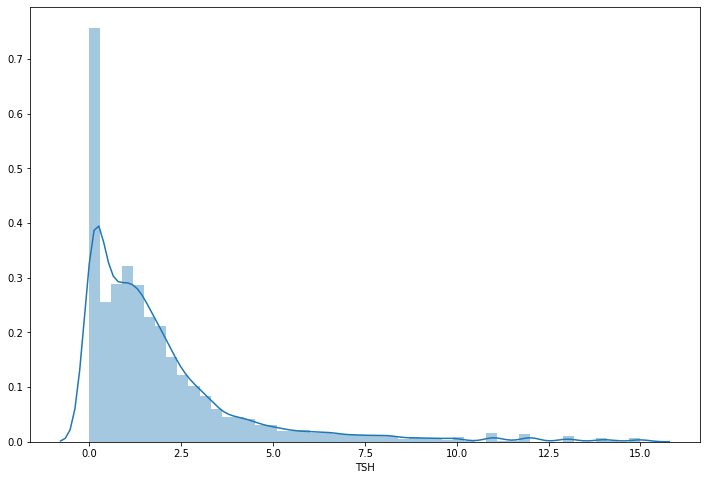

In [32]:
viz(df.TSH)

count    8348.000000
mean      111.005271
std        35.517806
min         4.000000
25%        89.000000
50%       105.000000
75%       127.000000
max       600.000000
Name: TT4, dtype: float64


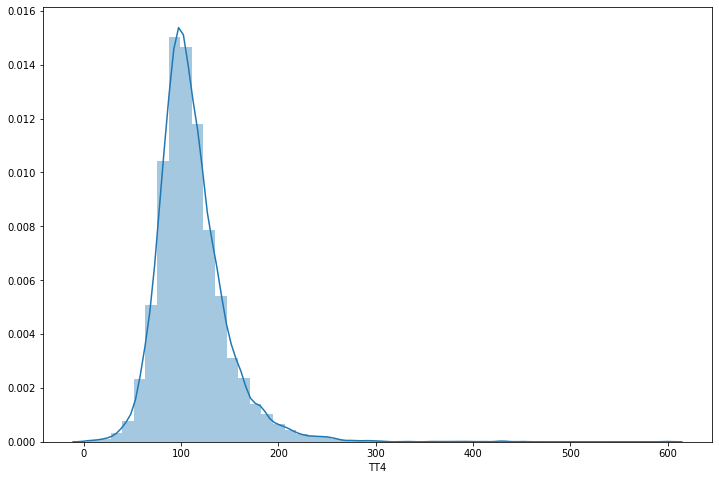

In [33]:
viz(df.TT4)

count    7999.000000
mean        0.972877
std         0.199258
min         0.170000
25%         0.860000
50%         0.960000
75%         1.060000
max         2.330000
Name: T4U, dtype: float64


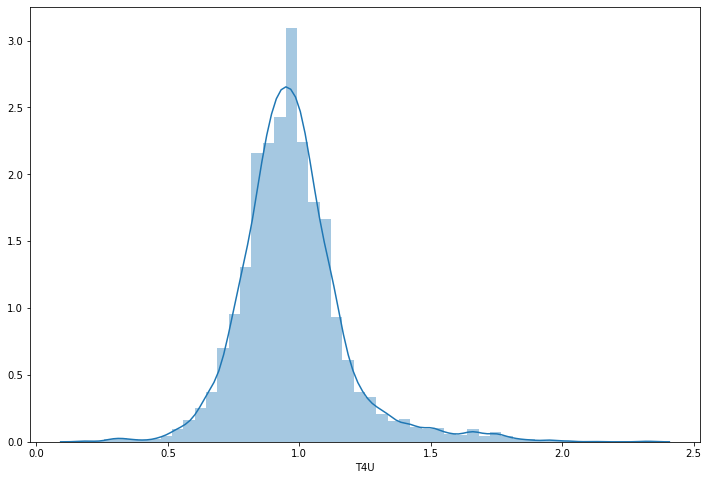

In [34]:
viz(df.T4U)

count    8006.000000
mean      116.250643
std        39.691636
min         3.500000
25%        95.000000
50%       110.000000
75%       129.000000
max       881.000000
Name: FTI, dtype: float64


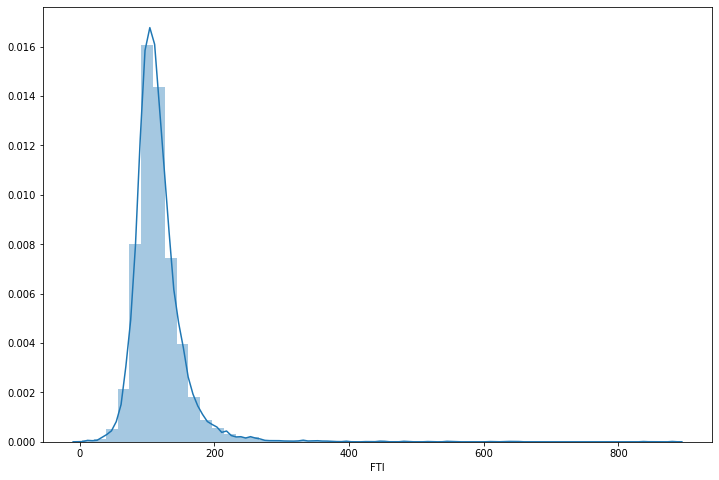

In [35]:
viz(df.FTI)

Majority of the numeric/continous features have outliers. Therefore we will scale our data using MinMaxScalar(Normalization).

In [119]:
# 1. Encoding the categorical features. 
# 2. Splitting the data into train, test and validation to prevent data leakage.
# 3. Imputing null values using KNNImputer.

df_dummy = pd.get_dummies(df)

validation_data = df_dummy[7000:]

def Imputation(df):
    imputer = KNNImputer(n_neighbors=3)
    df_1 = imputer.fit_transform(df)
    df_2 = pd.DataFrame(df_1, columns=df.columns)
    return df_2
    

df_final = Imputation(df_dummy[:7000])

x_train, x_test, y_train, y_test = train_test_split(df_final.drop(columns="outcome"), df_final["outcome"], test_size=0.2)

valid_final = Imputation(validation_data)

# Feature Engineering

In [120]:
#def add_features(df):
#    df["TSH_above_5"] = np.where(df["TSH"]>5, 1, 0) # normal range is 0.5 to 8
#    df["TT4_above_220"] = np.where(df["TT4"]>148, 1, 0) # normal range is 57 to 148
#    df["T4U_above_1.5"] = np.where(df["T4U"]>1.5, 1, 0)
#    df["FTI_above_200"] = np.where(df["FTI"]>200, 1, 0)
#    return df

#x_train = add_features(x_train)
#x_test = add_features(x_test)

In [121]:
def balance_data(x,y):    
    ros = RandomOverSampler(random_state=42)
    x_sample, y_sample = ros.fit_resample(x, y)
    return x_sample, y_sample

x_train, y_train = balance_data(x_train, y_train)
x_test, y_test = balance_data(x_test, y_test)
x_valid, y_valid = balance_data(valid_final.drop(columns="outcome"), valid_final["outcome"])

In [122]:
#sns.countplot(y_train)
#sns.countplot(y_test)
#sns.countplot(y_valid)

In [161]:
# Creating pipelies.

pipe1 = Pipeline([("minmax_scalar", MinMaxScaler()), ("logistic_regression", LogisticRegression())])

pipe2 = Pipeline([("minmax_scalar", MinMaxScaler()), ("KNN", KNeighborsClassifier())])

pipe3 = Pipeline([("minmax_scalar", MinMaxScaler()), ("svm", SVC())])

pipe4 = Pipeline([("minmax_scalar", MinMaxScaler()), ("XGboost", XGBClassifier())])

pipe5 = Pipeline([("minmax_scalar", MinMaxScaler()), ("decision_tree", DecisionTreeClassifier())])

pipe6 = Pipeline([("minmax_scalar", MinMaxScaler()), ("random_forest", RandomForestClassifier())])

def build_ann():
    
    model = keras.Sequential([
        
    layers.Dense(64, activation='relu', input_shape=[54]),
    
    layers.Dense(128, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')])
    
    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"])
    
    return model

ann_model = build_ann()

In [162]:
# Fitting the pipelines

pipelines = [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6]

for pipe in pipelines:
    pipe.fit(x_train, y_train)
    
    
callback = keras.callbacks.EarlyStopping(monitor = "val_binary_accuracy", patience=3, restore_best_weights=True)

history = ann_model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=32,
    epochs=100, 
    callbacks = [callback])

C:\Python\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train on 8566 samples, validate on 2174 samples
Epoch 1/100
8566/8566 [==============================] - 1s 116us/sample - loss: 0.7169 - binary_accuracy: 0.6603 - val_loss: 0.7415 - val_binary_accuracy: 0.6118
Epoch 2/100
8566/8566 [==============================] - 1s 110us/sample - loss: 0.5373 - binary_accuracy: 0.7445 - val_loss: 0.5309 - val_binary_accuracy: 0.7571
Epoch 3/100
8566/8566 [==============================] - 1s 76us/sample - loss: 0.5091 - binary_accuracy: 0.7609 - val_loss: 0.5081 - val_binary_accuracy: 0.7751
Epoch 4/100
8566/8566 [==============================] - 1s 87us/sample - loss: 0.4838 - binary_accuracy: 0.7816 - val_loss: 0.5169 - val_binary_accuracy: 0.7617
Epoch 5/100
8566/8566 [==============================] - 1s 77us/sample - loss: 0.4652 - binary_accuracy: 0.7927 - val_loss: 0.5489 - val_binary_accuracy: 0.7502
Epoch 6/100
8566/8566 [==============================] - 1s 84us/sample - loss: 0.4661 - binary_accuracy: 0.7937 - val_loss: 0.4787 - val_bi

In [163]:
# Predicting

pred1 = pipe1.predict(x_test)
pred2 = pipe2.predict(x_test)
pred3 = pipe3.predict(x_test)
pred4 = pipe4.predict(x_test)
pred5 = pipe5.predict(x_test)
pred6 = pipe6.predict(x_test)

In [164]:
# Comparing the result of each pipeline and selecting the best pipeline. 

print("Accuracy of Logistic_Regression", round(accuracy_score(y_test, pred1)*100, 2), "%")
print("Recall of Logistic_Regression", round(recall_score(y_test, pred1),2))
print("===================================================================")
print("Accuracy of KNN", round(accuracy_score(y_test, pred2)*100, 2), "%")
print("Recall of KNN", round(recall_score(y_test, pred2),2))
print("===================================================================")
print("Accuracy of SVC", round(accuracy_score(y_test, pred3)*100,2), "%")
print("Recall of SVC", round(recall_score(y_test, pred3),2))
print("===================================================================")
print("Accuracy of xgboost", round(accuracy_score(y_test, pred4)*100,2), "%")
print("Recall of xgboost", round(recall_score(y_test, pred4),2))
print("===================================================================")
print("Accuracy of decision_tree", round(accuracy_score(y_test, pred5)*100,2), "%")
print("Recall of decision_tree", round(recall_score(y_test, pred5),2))
print("===================================================================")
print("Accuracy of Random_forest", round(accuracy_score(y_test, pred6)*100,2), "%")
print("Recall of Random_forest", round(recall_score(y_test, pred6),2))

Accuracy of Logistic_Regression 69.46 %
Recall of Logistic_Regression 0.63
Accuracy of KNN 72.86 %
Recall of KNN 0.66
Accuracy of SVC 70.88 %
Recall of SVC 0.62
Accuracy of xgboost 82.43 %
Recall of xgboost 0.74
Accuracy of decision_tree 77.6 %
Recall of decision_tree 0.63
Accuracy of Random_forest 80.59 %
Recall of Random_forest 0.67


Boosting algorithms seem to work pretty well. Since XGBoost is giving highest accuracy so we will go with it.

In [131]:
# Applying selectKbest() to reduce the number of features.

#def feature_selection(x,y):
#    
#    obj = SelectKBest(f_regression, k=54)
#    new_data = obj.fit_transform(x,y)
#    filter = obj.get_support()
#    feature = x.columns
#    final_f = feature[filter]
#    print(final_f)
#    
#    return final_f

#features = feature_selection(x_train, y_train)


perm = PermutationImportance(pipe6, random_state=1).fit(x_test[features], y_test)
eli5.show_weights(perm, feature_names = x_test[features].columns.tolist())

Weight,Feature
0.1262 ± 0.0096,FTI
0.1089 ± 0.0181,TSH
0.0834 ± 0.0101,TT4
0.0563 ± 0.0078,T4U
0.0134 ± 0.0064,T3_measured_t
0.0126 ± 0.0028,referral_source_SVI
0.0107 ± 0.0036,T3_measured_f
0.0106 ± 0.0059,age
0.0078 ± 0.0006,TBG_measured_f
0.0053 ± 0.0018,TSH_measured_f


In [176]:
features = ["FTI", "TSH", "TT4", "T4U"]

In [181]:
# Using randomized search cv to get the best parameter values

def hyparameter_tuning_rf(model, x, y, final_features):
    params = { 
        'random_forest__max_depth': [15, 25, 30, 35, 45, 50],
        'random_forest__n_estimators': [50, 70, 100, 200, 300, 400]
             }

    tuned_model = RandomizedSearchCV(model, param_distributions=params, n_iter=3, cv=3)
    tuned_model.fit(x[final_features], y)
    print(tuned_model.best_params_)
    return tuned_model

model_rf = hyparameter_tuning_rf(pipe6, x_train, y_train, features)

{'random_forest__n_estimators': 100, 'random_forest__max_depth': 25}


In [182]:
# Using randomized search cv to get the best parameter values

def hyparameter_tuning_xgb(model, x, y, final_features):
    params = { 
       'XGboost__max_depth': [3,4,5,7,10,15,],
       'XGboost__learning_rate': [0.001, 0.0003, 0.005],
       'XGboost__n_estimators': [1000, 1500, 8000, 10000],
       'XGboost__colsample_bytree': [0.3, 0.5, 0.7, 0.9]
             }

    tuned_model = RandomizedSearchCV(model, param_distributions=params, n_iter=3, cv=3)
    tuned_model.fit(x[final_features], y)
    print(tuned_model.best_params_)
    return tuned_model

model_xgb = hyparameter_tuning_xgb(pipe4, x_train, y_train, features)

{'XGboost__n_estimators': 1500, 'XGboost__max_depth': 4, 'XGboost__learning_rate': 0.005, 'XGboost__colsample_bytree': 0.9}


In [183]:
# Ensembling the 3 model

pred_1 = model_rf.predict(x_test[features])
pred_2 = model_xgb.predict(x_test[features])

test_pred = (pred_1+pred_2)/2
test_pred = np.where(test_pred>=0.50, 1, 0)

print("RF ", round(accuracy_score(y_test, pred_1)*100,2), "%", "\nXGB", round(accuracy_score(y_test, pred_2)*100,2), "%", "\nEnsemble", round(accuracy_score(y_test, test_pred)*100,2))
#print("Recall of ensembled model", round(recall_score(y_test, test_pred),2))

RF  78.56 % 
XGB 78.98 % 
Ensemble 79.48


In [184]:
# Ensembling the 3 model

pred_4 = model_rf.predict(x_valid[features])
pred_5 = model_xgb.predict(x_valid[features])

valid_pred = (pred_4+pred_5)/2 
valid_pred = np.where(valid_pred>=0.50, 1, 0)

print("RF ", round(accuracy_score(y_valid, pred_4)*100,2), "%", "\nXGB", round(accuracy_score(y_valid, pred_5)*100,2), "%", "\nEnsemble", round(accuracy_score(y_valid, valid_pred)*100,2))
#print("Recall of ensembled model", round(recall_score(y_valid, valid_pred),2))

RF  81.12 % 
XGB 84.19 % 
Ensemble 83.25


In [188]:
# Finally saving our model as a pickel file. (For deployment)

pickle.dump(model_rf, open('Random_forest_model.pkl','wb'))
pickle.dump(model_xgb, open('XGBoost_model.pkl','wb'))